In [ ]:
# default_exp engine.model

In [ ]:
%load_ext autoreload
%autoreload 2

# DECODE Network

> Definition of the classes and modules we use to build our DECODE network

ToDo: Lots of bloat. Different normalizations aren't needed.

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
import types
from functools import partial
import torch.nn.functional as F

In [ ]:
#export
def number_of_features_per_level(init_channel_number, num_levels):
    return [init_channel_number * 2 ** k for k in range(num_levels)]

In [ ]:
#export
def create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding):
    """
    Create a list of modules with together constitute a single conv layer with non-linearity
    and optional batchnorm/groupnorm.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size(int or tuple): size of the convolving kernel
        order (string): order of things, e.g.
            'cr' -> conv + ReLU
            'gcr' -> groupnorm + conv + ReLU
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
            'bcr' -> batchnorm + conv + ReLU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    Return:
        list of tuple (name, module)
    """
    assert 'c' in order, "Conv layer MUST be present"
    assert order[0] not in 'rle', 'Non-linearity cannot be the first operation in the layer'

    modules = []
    for i, char in enumerate(order):
        if char == 'r':
            modules.append(('ReLU', nn.ReLU(inplace=True)))
        elif char == 'l':
            modules.append(('LeakyReLU', nn.LeakyReLU(negative_slope=0.1, inplace=True)))
        elif char == 'e':
            modules.append(('ELU', nn.ELU(inplace=True)))
        elif char == 'c':
            # add learnable bias only in the absence of batchnorm/groupnorm
            bias = not ('g' in order or 'b' in order)
            modules.append(('conv', nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=bias, padding_mode='replicate')))
        elif char == 'g':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                num_channels = in_channels
            else:
                num_channels = out_channels

            # use only one group if the given number of groups is greater than the number of channels
            if num_channels < num_groups:
                num_groups = 1

            assert num_channels % num_groups == 0, f'Expected number of channels in input to be divisible by num_groups. num_channels={num_channels}, num_groups={num_groups}'
            modules.append(('groupnorm', nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)))
        elif char == 'b':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                modules.append(('batchnorm', nn.BatchNorm3d(in_channels)))
            else:
                modules.append(('batchnorm', nn.BatchNorm3d(out_channels)))
        else:
            raise ValueError(f"Unsupported layer type '{char}'. MUST be one of ['b', 'g', 'r', 'l', 'e', 'c']")

    return modules

In [ ]:
#export
class SingleConv(nn.Sequential):
    """
    Basic convolutional module consisting of a Conv3d, non-linearity and optional batchnorm/groupnorm. The order
    of operations can be specified via the `order` parameter
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple):
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(SingleConv, self).__init__()

        for name, module in create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding=padding):
            self.add_module(name, module)

In [ ]:
#export
class DoubleConv(nn.Sequential):
    """
    A module consisting of two consecutive convolution layers (e.g. BatchNorm3d+ReLU+Conv3d).
    We use (Conv3d+ReLU+GroupNorm3d) by default.
    This can be changed however by providing the 'order' argument, e.g. in order
    to change to Conv3d+BatchNorm3d+ELU use order='cbe'.
    Use padded convolutions to make sure that the output (H_out, W_out) is the same
    as (H_in, W_in), so that you don't have to crop in the decoder path.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        encoder (bool): if True we're in the encoder path, otherwise we're in the decoder
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, encoder, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(DoubleConv, self).__init__()
        if encoder:
            # we're in the encoder path
            conv1_in_channels = in_channels
            conv1_out_channels = out_channels // 2
            if conv1_out_channels < in_channels:
                conv1_out_channels = in_channels
            conv2_in_channels, conv2_out_channels = conv1_out_channels, out_channels
        else:
            # we're in the decoder path, decrease the number of channels in the 1st convolution
            conv1_in_channels, conv1_out_channels = in_channels, out_channels
            conv2_in_channels, conv2_out_channels = out_channels, out_channels

        # conv1
        self.add_module('SingleConv1',
                        SingleConv(conv1_in_channels, conv1_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
        # conv2
        self.add_module('SingleConv2',
                        SingleConv(conv2_in_channels, conv2_out_channels, kernel_size, order, num_groups,
                                   padding=padding))

In [ ]:
#export
class Upsampling(nn.Module):
    """
    Upsamples a given multi-channel 3D data using either interpolation or learned transposed convolution.
    Args:
        transposed_conv (bool): if True uses ConvTranspose3d for upsampling, otherwise uses interpolation
        in_channels (int): number of input channels for transposed conv
            used only if transposed_conv is True
        out_channels (int): number of output channels for transpose conv
            used only if transposed_conv is True
        kernel_size (int or tuple): size of the convolving kernel
            used only if transposed_conv is True
        scale_factor (int or tuple): stride of the convolution
            used only if transposed_conv is True
        mode (str): algorithm used for upsampling:
            'nearest' | 'linear' | 'bilinear' | 'trilinear' | 'area'. Default: 'nearest'
            used only if transposed_conv is False
    """

    def __init__(self, transposed_conv, in_channels=None, out_channels=None, kernel_size=3,
                 scale_factor=(2, 2, 2), mode='nearest'):
        super(Upsampling, self).__init__()

        if transposed_conv:
            # make sure that the output size reverses the MaxPool3d from the corresponding encoder
            # (D_out = (D_in − 1) ×  stride[0] − 2 ×  padding[0] +  kernel_size[0] +  output_padding[0])
            self.upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=kernel_size, stride=scale_factor,
                                               padding=1)
        else:
            self.upsample = partial(self._interpolate, mode=mode)

    def forward(self, encoder_features, x):
        output_size = encoder_features.size()[2:]
        return self.upsample(x, output_size)

    @staticmethod
    def _interpolate(x, size, mode):
        return F.interpolate(x, size=size, mode=mode)

In [ ]:
#export
class Encoder(nn.Module):
    """
    A single module from the encoder path consisting of the optional max
    pooling layer (one may specify the MaxPool kernel_size to be different
    than the standard (2,2,2), e.g. if the volumetric data is anisotropic
    (make sure to use complementary scale_factor in the decoder path) followed by
    a DoubleConv module.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        apply_pooling (bool): if True use MaxPool3d before DoubleConv
        pool_kernel_size (int or tuple): the size of the window
        pool_type (str): pooling layer: 'max' or 'avg'
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, apply_pooling=True,
                 pool_kernel_size=2, pool_type='max', basic_module=DoubleConv, conv_layer_order='gcr',
                 num_groups=8, padding=1):
        super(Encoder, self).__init__()
        assert pool_type in ['max', 'avg']
        if apply_pooling:
            if pool_type == 'max':
                self.pooling = nn.MaxPool3d(kernel_size=pool_kernel_size)
            else:
                self.pooling = nn.AvgPool3d(kernel_size=pool_kernel_size)
        else:
            self.pooling = None

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=True,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, x):
        if self.pooling is not None:
            x = self.pooling(x)
        x = self.basic_module(x)
        return x

In [ ]:
#export
class Decoder(nn.Module):
    """
    A single module for decoder path consisting of the upsampling layer
    (either learned ConvTranspose3d or nearest neighbor interpolation) followed by a basic module (DoubleConv or ExtResNetBlock).
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        scale_factor (tuple): used as the multiplier for the image H/W/D in
            case of nn.Upsample or as stride in case of ConvTranspose3d, must reverse the MaxPool3d operation
            from the corresponding encoder
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, scale_factor=(2, 2, 2), basic_module=DoubleConv,
                 conv_layer_order='gcr', num_groups=8, mode='nearest', padding=1):
        super(Decoder, self).__init__()
        if basic_module == DoubleConv:
            # if DoubleConv is the basic_module use interpolation for upsampling and concatenation joining
            self.upsampling = Upsampling(transposed_conv=False, in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=conv_kernel_size, scale_factor=scale_factor, mode=mode)
            # concat joining
            self.joining = partial(self._joining, concat=True)
        else:
            # if basic_module=ExtResNetBlock use transposed convolution upsampling and summation joining
            self.upsampling = Upsampling(transposed_conv=True, in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=conv_kernel_size, scale_factor=scale_factor, mode=mode)
            # sum joining
            self.joining = partial(self._joining, concat=False)
            # adapt the number of in_channels for the ExtResNetBlock
            in_channels = out_channels

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=False,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, encoder_features, x):
        x = self.upsampling(encoder_features=encoder_features, x=x)
        x = self.joining(encoder_features, x)
        x = self.basic_module(x)
        return x

    @staticmethod
    def _joining(encoder_features, x, concat):
        if concat:
            return torch.cat((encoder_features, x), dim=1)
        else:
            return encoder_features + x

In [ ]:
#export
class Abstract3DUNet(nn.Module):
    """
    Base class for standard and residual UNet.
    Args:
        in_channels (int): number of input channels
        f_maps (int, tuple): number of feature maps at each level of the encoder; if it's an integer the number
            of feature maps is given by the geometric progression: f_maps ^ k, k=1,2,3,4
        final_sigmoid (bool): if True apply element-wise nn.Sigmoid after the
            final 1x1 convolution, otherwise apply nn.Softmax. MUST be True if nn.BCELoss (two-class) is used
            to train the model. MUST be False if nn.CrossEntropyLoss (multi-class) is used to train the model.
        basic_module: basic model for the encoder/decoder (DoubleConv, ExtResNetBlock, ....)
        layer_order (string): determines the order of layers
            in `SingleConv` module. e.g. 'crg' stands for Conv3d+ReLU+GroupNorm3d.
            See `SingleConv` for more info
        f_maps (int, tuple): if int: number of feature maps in the first conv layer of the encoder (default: 64);
            if tuple: number of feature maps at each level
        num_groups (int): number of groups for the GroupNorm
        num_levels (int): number of levels in the encoder/decoder path (applied only if f_maps is an int)
        is_segmentation (bool): if True (semantic segmentation problem) Sigmoid/Softmax normalization is applied
            after the final convolution; if False (regression problem) the normalization layer is skipped at the end
        testing (bool): if True (testing mode) the `final_activation` (if present, i.e. `is_segmentation=true`)
            will be applied as the last operation during the forward pass; if False the model is in training mode
            and the `final_activation` (even if present) won't be applied; default: False
        conv_kernel_size (int or tuple): size of the convolving kernel in the basic_module
        pool_kernel_size (int or tuple): the size of the window
        conv_padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, final_sigmoid, basic_module, f_maps=64, is_2D=False, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, testing=False,
                 conv_kernel_size=3, pool_kernel_size=2, conv_padding=1, **kwargs):
        super(Abstract3DUNet, self).__init__()

        self.testing = testing
        if is_2D:
            conv_kernel_size = [1, conv_kernel_size, conv_kernel_size]
            pool_kernel_size = [1, pool_kernel_size, pool_kernel_size]
            conv_padding = [0, conv_padding, conv_padding]

        if isinstance(f_maps, int):
            f_maps = number_of_features_per_level(f_maps, num_levels=num_levels)

        # create encoder path consisting of Encoder modules. Depth of the encoder is equal to `len(f_maps)`
        encoders = []
        for i, out_feature_num in enumerate(f_maps):
            if i == 0:
                encoder = Encoder(in_channels, out_feature_num,
                                  apply_pooling=False,  # skip pooling in the firs encoder
                                  basic_module=basic_module,
                                  conv_layer_order=layer_order,
                                  conv_kernel_size=conv_kernel_size,
                                  num_groups=num_groups,
                                  padding=conv_padding)
            else:
                # TODO: adapt for anisotropy in the data, i.e. use proper pooling kernel to make the data isotropic after 1-2 pooling operations
                encoder = Encoder(f_maps[i - 1], out_feature_num,
                                  basic_module=basic_module,
                                  conv_layer_order=layer_order,
                                  conv_kernel_size=conv_kernel_size,
                                  num_groups=num_groups,
                                  pool_kernel_size=pool_kernel_size,
                                  padding=conv_padding)

            encoders.append(encoder)

        self.encoders = nn.ModuleList(encoders)

        # create decoder path consisting of the Decoder modules. The length of the decoder is equal to `len(f_maps) - 1`
        decoders = []
        reversed_f_maps = list(reversed(f_maps))
        for i in range(len(reversed_f_maps) - 1):
            if basic_module == DoubleConv:
                in_feature_num = reversed_f_maps[i] + reversed_f_maps[i + 1]
            else:
                in_feature_num = reversed_f_maps[i]

            out_feature_num = reversed_f_maps[i + 1]
            # TODO: if non-standard pooling was used, make sure to use correct striding for transpose conv
            # currently strides with a constant stride: (2, 2, 2)
            decoder = Decoder(in_feature_num, out_feature_num,
                              basic_module=basic_module,
                              conv_layer_order=layer_order,
                              conv_kernel_size=conv_kernel_size,
                              num_groups=num_groups,
                              padding=conv_padding)
            decoders.append(decoder)

        self.decoders = nn.ModuleList(decoders)

    def forward(self, x):
        # encoder part
        encoders_features = []
        for encoder in self.encoders:
            x = encoder(x)
            # reverse the encoder outputs to be aligned with the decoder
            encoders_features.insert(0, x)

        # remove the last encoder's output from the list
        # !!remember: it's the 1st in the list
        encoders_features = encoders_features[1:]

        # decoder part
        for decoder, encoder_features in zip(self.decoders, encoders_features):
            # pass the output from the corresponding encoder and the output
            # of the previous decoder
            x = decoder(encoder_features, x)
            
        return x

In [ ]:
#export
class UNet3D(Abstract3DUNet):
    """
    3DUnet model from
    `"3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation"
        <https://arxiv.org/pdf/1606.06650.pdf>`.
    Uses `DoubleConv` as a basic_module and nearest neighbor upsampling in the decoder
    """

    def __init__(self, in_channels, final_sigmoid=True, f_maps=64, is_2D=False, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1,  **kwargs):
        super(UNet3D, self).__init__(in_channels=in_channels, final_sigmoid=final_sigmoid,
                                     basic_module=DoubleConv, f_maps=f_maps, is_2D=is_2D, layer_order=layer_order,
                                     num_groups=num_groups, num_levels=num_levels, is_segmentation=is_segmentation,
                                     conv_padding=conv_padding, **kwargs)

In [ ]:
#export  
class OutputNet(nn.Module):
    """
    Takes the output maps from the U-net and processes them seperately, using two conv3D layers for each group (xyzi_mean, xyzi_sigma, probability, background)
    Args:
        f_maps: number of channels of the U-net output
        p_offset: probability channel bias 
        is_2D: whether the input is 1D in the z dimension
        n_p_ch: Number probability channels (number of genes + number of channels)
        n_bg_ch: Number background channels (number of channels or 1)
        n_int_ch: Number intensity channels (number of channels)
        
    """
    def __init__(self, f_maps=64, p_offset=-5., is_2D=False, n_p_ch=1, n_bg_ch=1, n_int_ch=1.):
        super().__init__()
        
        self.is_2D = is_2D
        self.n_p_ch = n_p_ch
        self.n_bg_ch = n_bg_ch
        self.n_int_ch = n_int_ch
        self.p_offset = p_offset
        
        xyzi_dim = 3 + n_int_ch
        
        kernel_size = [1,3,3] if is_2D else [3,3,3]
        padding = [0,1,1] if is_2D else [1,1,1]
        
        
        self.p_out1 = nn.Conv3d(f_maps, f_maps, kernel_size=kernel_size, padding=padding, padding_mode='replicate')
        self.p_out2 = nn.Conv3d(f_maps, n_p_ch, kernel_size=1, padding=0)
        nn.init.constant_(self.p_out2.bias,p_offset)
        
        self.xyzi_out1 = nn.Conv3d(f_maps, f_maps, kernel_size=kernel_size, padding=padding, padding_mode='replicate')
        self.xyzi_out2 = nn.Conv3d(f_maps, xyzi_dim, kernel_size=1, padding=0)
        
        self.xyzis_out1 = nn.Conv3d(f_maps, f_maps, kernel_size=kernel_size, padding=padding, padding_mode='replicate')
        self.xyzis_out2 = nn.Conv3d(f_maps, xyzi_dim, kernel_size=1, padding=0)
        
        self.bg_out1 = nn.Conv3d(f_maps + n_int_ch, f_maps, kernel_size=kernel_size, padding=padding, padding_mode='replicate')
        self.bg_out2 = nn.Conv3d(f_maps, n_bg_ch, kernel_size=1, padding=0)
        
        nn.init.kaiming_normal_(self.p_out1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.p_out2.weight, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.xyzi_out1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.xyzi_out2.weight, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.xyzis_out1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.xyzis_out2.weight, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.bg_out1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.bg_out2.weight, mode='fan_in', nonlinearity='linear')    
        
    def forward(self, u_net_out, resid_x):
        
        # Sigmoid is applied later
        logit    = F.elu(self.p_out1(u_net_out))
        logit    = self.p_out2(logit)
        logit    = torch.clamp(logit, -20., 20)
        
        xyzi = F.elu(self.xyzi_out1(u_net_out))
        xyzi = self.xyzi_out2(xyzi)
        
        # xyz [-1, 1]
        xyz_mu   = torch.tanh(xyzi[:, :3])

        # xyz [0, :]
        i_mu     = F.softplus(xyzi[:, 3:])
        xyzi_mu = torch.cat((xyz_mu, i_mu), dim=1)
        
        xyzis = F.elu(self.xyzis_out1(u_net_out))
        xyzis = self.xyzis_out2(xyzis)
        # sigmas [0.01, :]
        xyzi_sig = F.softplus(xyzis) + 0.01
        
        # We use a residual connection from input to facilitate background prediction
        bg_inp = torch.cat([u_net_out, resid_x], 1)
        
        background = F.elu(self.bg_out1(bg_inp))
        background = self.bg_out2(background)
        # sigmas [0., :]
        background = F.softplus(background)
        
        return torch.cat([logit,xyzi_mu,xyzi_sig,background],1)

In [ ]:
# export
class UnetDecodeNoBn_2S(nn.Module):
    """
    Our DECODE network consists of two 3D U-nets, and an output net module.
    The first (small) network runs over each input channel seperately (shared parameters), the second combines information from all channels.
    The network parameters can be accessed through model.network
    
    The forward function returns a tensor batch_size x n_output_channel tensor to make it compatible with the monai.inferers.sliding_window_inference function.
    
    To get the final output dictionary one has to also apply the tensor_to_dict function.
    
    Args:
        ch_in (int): number of input channels (i.e. n_rounds * n_colors)
        depth (int): number of levels in the encoder/decoder path of the second U-net
        inp_offset, inp_scale (float): Values used for scaling the input. 
        order (string): determines the order of layers
            in `SingleConv` module. e.g. 'ce' stands for Conv3d+ELU.
            See `SingleConv` for more info
        f_maps (int, tuple): number of feature maps at each level of the encoder; if it's an integer the number
            of feature maps is given by the geometric progression: f_maps ^ k, k=1,2,3,4
        is_2D: whether the input is 1D in the z dimension (i.e. slice data)
        pred_z: setting to false will disable inference of the z position
        p_offset (float): bias of the probabilty channel. The negative value avoids very high rates at the start of the training which might cause memory issues.
        n_p_ch: Number probability channels (number of genes + number of channels)
        n_bg_ch: Number background channels (number of channels or 1)
        n_int_ch: Number intensity channels (number of channels)
        n_chrom_map_ch: number of colors of. If you dont want to use chromatic abberation map as an additional input set to 0   
    """
    def __init__(self, ch_in=1, depth=3, inp_scale=1., inp_offset=0., order='ce', f_maps=64, 
                 is_2D=False, pred_z=True, p_offset=-5., int_conc=4., int_rate=1., int_loc=1., n_p_ch=1, n_bg_ch=1, n_int_ch=1, n_chrom_map_ch=False):
        super().__init__()
        
        self.inp_scale = inp_scale
        self.inp_offset = inp_offset
        
        self.n_chrom_map_ch = n_chrom_map_ch

        self.n_ch = ch_in
        self.is_2D = is_2D
        self.pred_z = pred_z
        self.n_p_ch = n_p_ch
        self.n_bg_ch = n_bg_ch
        self.n_int_ch = n_int_ch
            
        self.single_n_ch = 12
        ch_in = self.n_ch * self.single_n_ch
        ch_in = ch_in + self.n_chrom_map_ch

        self.single_ch_unet = UNet3D(1, final_sigmoid=False, num_levels=1, is_2D=is_2D, layer_order = order, f_maps=self.single_n_ch)
        self.unet = UNet3D(ch_in, final_sigmoid=False, num_levels=depth, is_2D=is_2D, layer_order = order, f_maps=f_maps)
        self.outnet = OutputNet(f_maps=f_maps, p_offset=p_offset, is_2D=is_2D, n_p_ch=n_p_ch, n_bg_ch=n_bg_ch, n_int_ch=n_int_ch)  
            
        self.network = nn.ModuleList([self.single_ch_unet, self.unet, self.outnet])
            
    def forward(self, x):

        if self.n_chrom_map_ch:
            # Don't scale chrom. map input
            x[:,:-self.n_chrom_map_ch] = (x[:,:-self.n_chrom_map_ch]-self.inp_offset) / self.inp_scale
        else:
            x = (x-self.inp_offset) / self.inp_scale
            
        s_x = x[:,:-self.n_chrom_map_ch] if self.n_chrom_map_ch else x
        single_ch_out = self.network[0](s_x.flatten(0,1)[:,None]).reshape(s_x.shape[0],-1,*s_x.shape[2:])
        m_x = torch.cat([single_ch_out, x[:,-self.n_chrom_map_ch:]], 1) if self.n_chrom_map_ch else single_ch_out
        unet_out = self.network[1](m_x)

        res_x = x[:,:-self.n_chrom_map_ch] if self.n_chrom_map_ch else x
        net_out = self.network[-1](unet_out, res_x)
            
        return net_out
        
    def tensor_to_dict(self, x):
        
        logits = x[:, 0:self.n_p_ch]
        xyzi_mu = x[:, self.n_p_ch:self.n_p_ch+3+self.n_int_ch]
        xyzi_sig = x[:, self.n_p_ch+3+self.n_int_ch:self.n_p_ch+2*(3+self.n_int_ch)]
        bg = x[:, self.n_p_ch+2*(3+self.n_int_ch):self.n_p_ch+2*(3+self.n_int_ch)+self.n_bg_ch]
        
        # Scale bg output
        bg = bg * self.inp_scale
    
        if not self.pred_z:
            # If we don't want to predict z, set mu to 0 and sigma to 1
            xyzi_mu[:,2] *= 0
            xyzi_sig[:,2] *= 0
            xyzi_sig[:,2] += 1

        ret_dict = {'logits': logits, 
                    'xyzi_mu': xyzi_mu, 
                    'xyzi_sigma': xyzi_sig, 
                    'background': bg}
        
        return ret_dict

In [ ]:
inp = torch.randn([2,9,1,48,48])

In [ ]:
model = UnetDecodeNoBn_2S(order= 'ce', ch_in=22, f_maps=256, depth=2, is_2D=True, pred_z=False, n_p_ch=252 + 22, n_bg_ch=22, n_int_ch=22, n_chrom_map_ch=0)
output = model.tensor_to_dict(model(torch.randn([3,22,1,48,48])))

for k in output.keys():
    print(k, output[k].shape)

logits torch.Size([3, 274, 1, 48, 48])
xyzi_mu torch.Size([3, 25, 1, 48, 48])
xyzi_sigma torch.Size([3, 25, 1, 48, 48])
background torch.Size([3, 22, 1, 48, 48])


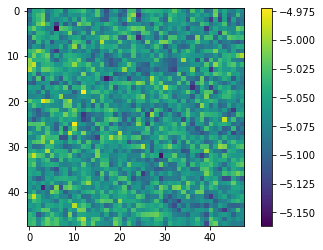

In [ ]:
plt.imshow((output['logits'])[0,0,0].detach().numpy())
plt.colorbar()

In [ ]:
output = model.tensor_to_dict(model.cuda()(torch.randn([2,22,3,48,48]).cuda()))
torch.save(output, '../data/model_batch_output_class5.pt')

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [ ]:
sum(p.numel() for p in model.network.parameters())

7866738

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
